In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil


# Source folder in Google Drive
src_folder = '/content/drive/My Drive/Datasets'

# Destination folder in Colab local storage
dest_folder = '/content/Dataset'

# Copy the folder
shutil.copytree(src_folder, dest_folder)

'/content/Dataset'

In [19]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import jaccard_score
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


class BDD100KDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name.replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


train_dataset = BDD100KDataset(
    images_dir='./Dataset/100k_images_train_small_data/bdd100k/images/100k/train',
    masks_dir='./Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/train',
    transform=transform
)

val_dataset = BDD100KDataset(
    images_dir='./Dataset/100k_images_val_small_data/bdd100k/images/100k/val',
    masks_dir='./Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val',
    transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

# Instantiate the model
model = UNet(in_channels=3, out_channels=1).cuda()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, model_path='unet_lane_detection.pth', start_epoch=0):
    best_val_loss = float('inf')

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for images, masks in train_loader_tqdm:
            images = images.cuda()
            masks = masks.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_loader_tqdm.set_postfix({'Loss': train_loss / len(train_loader.dataset)})

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
        with torch.no_grad():
            for images, masks in val_loader_tqdm:
                images = images.cuda()
                masks = masks.cuda()

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)
                val_loader_tqdm.set_postfix({'Loss': val_loss / len(val_loader.dataset)})

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

        # Save the model after every 20 epoch
        if(epoch+1) % 20 == 0:
          torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epoch': epoch
          }, f'unet_lane_detection_epoch_{epoch+1}.pth')

        # Additionally, save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch
            }, 'best_unet_lane_detection.pth')


# Criterion and optimizer setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, model_path='unet_lane_detection.pth')



Epoch 1/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.702]


Epoch 1/100, Train Loss: 0.5823, Val Loss: 0.7025


Epoch 2/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, Loss=0.426]


Epoch 2/100, Train Loss: 0.3430, Val Loss: 0.4260


Epoch 3/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s, Loss=0.275]


Epoch 3/100, Train Loss: 0.2780, Val Loss: 0.2753


Epoch 4/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s, Loss=0.281]


Epoch 4/100, Train Loss: 0.2342, Val Loss: 0.2807


Epoch 5/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s, Loss=0.232]


Epoch 5/100, Train Loss: 0.2028, Val Loss: 0.2320


Epoch 6/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s, Loss=0.199]


Epoch 6/100, Train Loss: 0.1767, Val Loss: 0.1995


Epoch 7/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, Loss=0.172]


Epoch 7/100, Train Loss: 0.1551, Val Loss: 0.1723


Epoch 8/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, Loss=0.149]


Epoch 8/100, Train Loss: 0.1382, Val Loss: 0.1485


Epoch 9/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s, Loss=0.131]


Epoch 9/100, Train Loss: 0.1241, Val Loss: 0.1307


Epoch 10/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.117]


Epoch 10/100, Train Loss: 0.1121, Val Loss: 0.1165


Epoch 11/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.106]


Epoch 11/100, Train Loss: 0.1026, Val Loss: 0.1056


Epoch 12/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s, Loss=0.102]


Epoch 12/100, Train Loss: 0.0946, Val Loss: 0.1019


Epoch 13/100 - Validation: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s, Loss=0.0912]


Epoch 13/100, Train Loss: 0.0873, Val Loss: 0.0912


Epoch 14/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, Loss=0.0827]


Epoch 14/100, Train Loss: 0.0810, Val Loss: 0.0827


Epoch 15/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, Loss=0.0772]


Epoch 15/100, Train Loss: 0.0751, Val Loss: 0.0772


Epoch 16/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0728]


Epoch 16/100, Train Loss: 0.0708, Val Loss: 0.0728


Epoch 17/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, Loss=0.0685]


Epoch 17/100, Train Loss: 0.0673, Val Loss: 0.0685


Epoch 18/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s, Loss=0.0649]


Epoch 18/100, Train Loss: 0.0632, Val Loss: 0.0649


Epoch 19/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, Loss=0.0616]


Epoch 19/100, Train Loss: 0.0602, Val Loss: 0.0616


Epoch 20/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0599]


Epoch 20/100, Train Loss: 0.0576, Val Loss: 0.0599


Epoch 21/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0575]


Epoch 21/100, Train Loss: 0.0552, Val Loss: 0.0575


Epoch 22/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0548]


Epoch 22/100, Train Loss: 0.0533, Val Loss: 0.0548


Epoch 23/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s, Loss=0.0544]


Epoch 23/100, Train Loss: 0.0514, Val Loss: 0.0544


Epoch 24/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s, Loss=0.0524]


Epoch 24/100, Train Loss: 0.0498, Val Loss: 0.0524


Epoch 25/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s, Loss=0.0506]


Epoch 25/100, Train Loss: 0.0484, Val Loss: 0.0506


Epoch 26/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.0496]


Epoch 26/100, Train Loss: 0.0470, Val Loss: 0.0496


Epoch 27/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0479]


Epoch 27/100, Train Loss: 0.0459, Val Loss: 0.0479


Epoch 28/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s, Loss=0.0474]


Epoch 28/100, Train Loss: 0.0449, Val Loss: 0.0474


Epoch 29/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s, Loss=0.0474]


Epoch 29/100, Train Loss: 0.0442, Val Loss: 0.0474


Epoch 30/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0463]


Epoch 30/100, Train Loss: 0.0436, Val Loss: 0.0463


Epoch 31/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0453]


Epoch 31/100, Train Loss: 0.0426, Val Loss: 0.0453


Epoch 32/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.045]


Epoch 32/100, Train Loss: 0.0420, Val Loss: 0.0450


Epoch 33/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s, Loss=0.0449]


Epoch 33/100, Train Loss: 0.0412, Val Loss: 0.0449


Epoch 34/100 - Validation: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s, Loss=0.0443]


Epoch 34/100, Train Loss: 0.0407, Val Loss: 0.0443


Epoch 35/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0434]


Epoch 35/100, Train Loss: 0.0401, Val Loss: 0.0434


Epoch 36/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.0433]


Epoch 36/100, Train Loss: 0.0396, Val Loss: 0.0433


Epoch 37/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0419]


Epoch 37/100, Train Loss: 0.0391, Val Loss: 0.0419


Epoch 38/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s, Loss=0.0428]


Epoch 38/100, Train Loss: 0.0387, Val Loss: 0.0428


Epoch 39/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s, Loss=0.0412]


Epoch 39/100, Train Loss: 0.0384, Val Loss: 0.0412


Epoch 40/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0422]


Epoch 40/100, Train Loss: 0.0382, Val Loss: 0.0422


Epoch 41/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0409]


Epoch 41/100, Train Loss: 0.0378, Val Loss: 0.0409


Epoch 42/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.0408]


Epoch 42/100, Train Loss: 0.0371, Val Loss: 0.0408


Epoch 43/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s, Loss=0.0414]


Epoch 43/100, Train Loss: 0.0373, Val Loss: 0.0414


Epoch 44/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s, Loss=0.0408]


Epoch 44/100, Train Loss: 0.0369, Val Loss: 0.0408


Epoch 45/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0396]


Epoch 45/100, Train Loss: 0.0365, Val Loss: 0.0396


Epoch 46/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0394]


Epoch 46/100, Train Loss: 0.0360, Val Loss: 0.0394


Epoch 47/100 - Validation: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, Loss=0.0399]


Epoch 47/100, Train Loss: 0.0357, Val Loss: 0.0399


Epoch 48/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0381]


Epoch 48/100, Train Loss: 0.0355, Val Loss: 0.0381


Epoch 49/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0382]


Epoch 49/100, Train Loss: 0.0351, Val Loss: 0.0382


Epoch 50/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0385]


Epoch 50/100, Train Loss: 0.0349, Val Loss: 0.0385


Epoch 51/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, Loss=0.037]


Epoch 51/100, Train Loss: 0.0342, Val Loss: 0.0370


Epoch 52/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s, Loss=0.0384]


Epoch 52/100, Train Loss: 0.0343, Val Loss: 0.0384


Epoch 53/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0369]


Epoch 53/100, Train Loss: 0.0342, Val Loss: 0.0369


Epoch 54/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.0377]


Epoch 54/100, Train Loss: 0.0329, Val Loss: 0.0377


Epoch 55/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s, Loss=0.0355]


Epoch 55/100, Train Loss: 0.0325, Val Loss: 0.0355


Epoch 56/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, Loss=0.0362]


Epoch 56/100, Train Loss: 0.0323, Val Loss: 0.0362


Epoch 57/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0391]


Epoch 57/100, Train Loss: 0.0327, Val Loss: 0.0391


Epoch 58/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0366]


Epoch 58/100, Train Loss: 0.0320, Val Loss: 0.0366


Epoch 59/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, Loss=0.038]


Epoch 59/100, Train Loss: 0.0316, Val Loss: 0.0380


Epoch 60/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0342]


Epoch 60/100, Train Loss: 0.0312, Val Loss: 0.0342


Epoch 61/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0351]


Epoch 61/100, Train Loss: 0.0311, Val Loss: 0.0351


Epoch 62/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0348]


Epoch 62/100, Train Loss: 0.0308, Val Loss: 0.0348


Epoch 63/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, Loss=0.0348]


Epoch 63/100, Train Loss: 0.0311, Val Loss: 0.0348


Epoch 64/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0342]


Epoch 64/100, Train Loss: 0.0304, Val Loss: 0.0342


Epoch 65/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0338]


Epoch 65/100, Train Loss: 0.0305, Val Loss: 0.0338


Epoch 66/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0344]


Epoch 66/100, Train Loss: 0.0299, Val Loss: 0.0344


Epoch 67/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, Loss=0.0328]


Epoch 67/100, Train Loss: 0.0299, Val Loss: 0.0328


Epoch 68/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0391]


Epoch 68/100, Train Loss: 0.0296, Val Loss: 0.0391


Epoch 69/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0355]


Epoch 69/100, Train Loss: 0.0293, Val Loss: 0.0355


Epoch 70/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, Loss=0.0345]


Epoch 70/100, Train Loss: 0.0290, Val Loss: 0.0345


Epoch 71/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s, Loss=0.0334]


Epoch 71/100, Train Loss: 0.0291, Val Loss: 0.0334


Epoch 72/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, Loss=0.0319]


Epoch 72/100, Train Loss: 0.0286, Val Loss: 0.0319


Epoch 73/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0319]


Epoch 73/100, Train Loss: 0.0286, Val Loss: 0.0319


Epoch 74/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0324]


Epoch 74/100, Train Loss: 0.0283, Val Loss: 0.0324


Epoch 75/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, Loss=0.0315]


Epoch 75/100, Train Loss: 0.0283, Val Loss: 0.0315


Epoch 76/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0315]


Epoch 76/100, Train Loss: 0.0285, Val Loss: 0.0315


Epoch 77/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0358]


Epoch 77/100, Train Loss: 0.0284, Val Loss: 0.0358


Epoch 78/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, Loss=0.0321]


Epoch 78/100, Train Loss: 0.0284, Val Loss: 0.0321


Epoch 79/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s, Loss=0.0315]


Epoch 79/100, Train Loss: 0.0279, Val Loss: 0.0315


Epoch 80/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, Loss=0.0327]


Epoch 80/100, Train Loss: 0.0280, Val Loss: 0.0327


Epoch 81/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, Loss=0.0313]


Epoch 81/100, Train Loss: 0.0276, Val Loss: 0.0313


Epoch 82/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.032]


Epoch 82/100, Train Loss: 0.0272, Val Loss: 0.0320


Epoch 83/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s, Loss=0.0305]


Epoch 83/100, Train Loss: 0.0271, Val Loss: 0.0305


Epoch 84/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s, Loss=0.0316]


Epoch 84/100, Train Loss: 0.0268, Val Loss: 0.0316


Epoch 85/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0319]


Epoch 85/100, Train Loss: 0.0269, Val Loss: 0.0319


Epoch 86/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0324]


Epoch 86/100, Train Loss: 0.0270, Val Loss: 0.0324


Epoch 87/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s, Loss=0.0311]


Epoch 87/100, Train Loss: 0.0266, Val Loss: 0.0311


Epoch 88/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, Loss=0.0303]


Epoch 88/100, Train Loss: 0.0265, Val Loss: 0.0303


Epoch 89/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, Loss=0.0309]


Epoch 89/100, Train Loss: 0.0265, Val Loss: 0.0309


Epoch 90/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s, Loss=0.0319]


Epoch 90/100, Train Loss: 0.0269, Val Loss: 0.0319


Epoch 91/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s, Loss=0.031]


Epoch 91/100, Train Loss: 0.0269, Val Loss: 0.0310


Epoch 92/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0343]


Epoch 92/100, Train Loss: 0.0271, Val Loss: 0.0343


Epoch 93/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, Loss=0.0321]


Epoch 93/100, Train Loss: 0.0274, Val Loss: 0.0321


Epoch 94/100 - Validation: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, Loss=0.0324]


Epoch 94/100, Train Loss: 0.0274, Val Loss: 0.0324


Epoch 95/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0302]


Epoch 95/100, Train Loss: 0.0268, Val Loss: 0.0302


Epoch 96/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, Loss=0.0313]


Epoch 96/100, Train Loss: 0.0267, Val Loss: 0.0313


Epoch 97/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, Loss=0.0307]


Epoch 97/100, Train Loss: 0.0264, Val Loss: 0.0307


Epoch 98/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s, Loss=0.0344]


Epoch 98/100, Train Loss: 0.0268, Val Loss: 0.0344


Epoch 99/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0332]


Epoch 99/100, Train Loss: 0.0265, Val Loss: 0.0332


Epoch 100/100 - Validation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, Loss=0.0315]


Epoch 100/100, Train Loss: 0.0264, Val Loss: 0.0315


In [3]:
!nvidia-smi

Fri Nov 22 00:29:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
torch.cuda.is_available()

True

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from tqdm import tqdm
import os
from PIL import Image


# Set the environment variable for CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Resize to match the input size of the model
])

# Custom dataset class
class BDD100KDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Load the trained model
model = UNet(in_channels=3, out_channels=1).cuda()
model.load_state_dict(torch.load('best_unet_lane_detection.pth')['model_state_dict'])
model.eval()

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Load validation data
val_image_dir = './Dataset/100k_images_val_small_data/bdd100k/images/100k/val'
val_mask_dir = './Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val'
val_dataset = BDD100KDataset(val_image_dir, val_mask_dir, transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluation function
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    val_f1 = 0.0
    val_jaccard = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Evaluating'):
            images = images.cuda()
            masks = masks.cuda()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            true = masks.cpu().numpy() > 0.5

            val_accuracy += accuracy_score(true.flatten(), preds.flatten())
            val_f1 += f1_score(true.flatten(), preds.flatten())
            val_jaccard += jaccard_score(true.flatten(), preds.flatten())

    val_loss /= num_batches
    val_accuracy /= num_batches
    val_f1 /= num_batches
    val_jaccard /= num_batches

    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')
    print(f'Validation Jaccard Score: {val_jaccard:.4f}')

# Run evaluation
evaluate(model, val_loader, criterion)


<ipython-input-10-53e217c0b3bb>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet_lane_detection.pth')['model_state_dict'])
Eval

Validation Loss: 0.3216
Validation Accuracy: 0.9945
Validation F1 Score: 0.9972
Validation Jaccard Score: 0.9945


<ipython-input-7-d0fb5f56f2c5>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet_lane_detection.pth', map_location=torch.device('

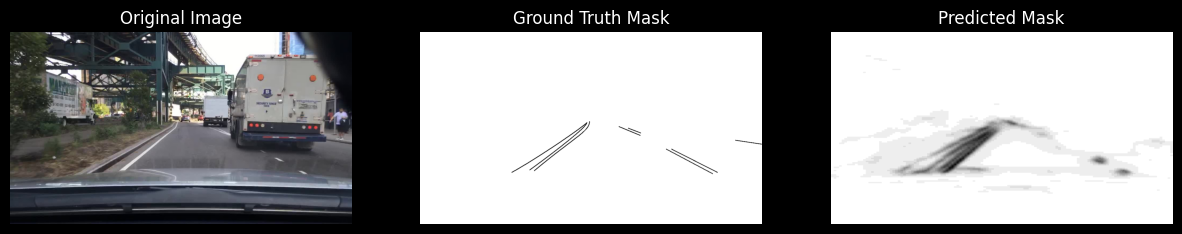

In [7]:

from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

plt.style.use('dark_background')

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

# Load the trained model
model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load('best_unet_lane_detection.pth', map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the input size used during training
    transforms.ToTensor()
])

# Function to preprocess the image and mask
def preprocess(image_path, mask_path):
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')  # Grayscale for mask
    original_size = image.size  # Keep original size
    image = transform(image)
    mask = transform(mask)
    return image, mask, original_size

# Function to post-process the output
def postprocess(output, original_size):
    output = output.squeeze().cpu().numpy()
    output = np.uint8(output * 255)  # Scale to 0-255
    output = Image.fromarray(output).resize(original_size, Image.BILINEAR)
    output = np.array(output)
    return output

# Function to display the results
def display_results(image_path, mask_path, predicted_mask):
    original_image = Image.open(image_path).convert('RGB')
    ground_truth_mask = Image.open(mask_path).convert('L')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask,cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis('off')

    plt.show()

def run_inference(image_path, mask_path):
    image, mask, original_size = preprocess(image_path, mask_path)
    image = image.unsqueeze(0)  # Add batch dimension, no need to move to GPU

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities

    predicted_mask = postprocess(output, original_size)

    # Save predicted mask
    save_folder = './Dataset/Predicted'
    os.makedirs(save_folder, exist_ok=True)
    predicted_mask_image = Image.fromarray(predicted_mask)
    predicted_mask_image.save(os.path.join(save_folder, os.path.basename(mask_path)))

    display_results(image_path, mask_path, predicted_mask)

# Example usage
image_path = './Dataset/100k_images_val_small_data/bdd100k/images/100k/val/b1e0c01d-dd9e6e2f.jpg'
mask_path = './Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val/b1e0c01d-dd9e6e2f.png'
run_inference(image_path, mask_path)

In [18]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import jaccard_score
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


class BDD100KDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name.replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


train_dataset = BDD100KDataset(
    images_dir='./Dataset/100k_images_train_small_data/bdd100k/images/100k/train',
    masks_dir='./Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/train',
    transform=transform
)

val_dataset = BDD100KDataset(
    images_dir='./Dataset/100k_images_val_small_data/bdd100k/images/100k/val',
    masks_dir='./Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val',
    transform=transform
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)



class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.W_x = nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # g: gating signal from the decoder
        # x: feature map from the encoder
        g = self.W_g(g)
        x = self.W_x(x)

        # Combine the two signals
        attn = self.relu(g + x)
        attn = self.psi(attn)
        attn = self.sigmoid(attn)

        # Apply the attention map to the feature map x
        return x * attn


class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attn4 = AttentionGate(512, 512, 256)  # Attention Gate for the skip connection
        self.dec4 = CBR(768, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn3 = AttentionGate(256, 256, 128)  # Attention Gate for the skip connection
        self.dec3 = CBR(384, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attn2 = AttentionGate(128, 128, 64)  # Attention Gate for the skip connection
        self.dec2 = CBR(192, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attn1 = AttentionGate(64, 64, 32)  # Attention Gate for the skip connection
        self.dec1 = CBR(96, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding path
        # dec4
        dec4 = self.upconv4(bottleneck)
        attn4 = self.attn4.forward(enc4, dec4)  # Apply attention gate
        dec4 = torch.cat((attn4, dec4), dim=1)  # Concatenate attention output and upsampled feature map
        dec4 = self.dec4(dec4)  # Adjust the number of input channels expected here

        # dec3
        dec3 = self.upconv3(dec4)
        attn3 = self.attn3.forward(enc3, dec3)  # Apply attention gate
        dec3 = torch.cat((attn3, dec3), dim=1)
        dec3 = self.dec3(dec3)

        # dec2
        dec2 = self.upconv2(dec3)
        attn2 = self.attn2.forward(enc2, dec2)  # Apply attention gate
        dec2 = torch.cat((attn2, dec2), dim=1)
        dec2 = self.dec2(dec2)

        # dec1
        dec1 = self.upconv1(dec2)
        attn1 = self.attn1.forward(enc1, dec1)  # Apply attention gate
        dec1 = torch.cat((attn1, dec1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))


# Instantiate the model with attention
model_with_attention = UNetWithAttention(in_channels=3, out_channels=1).cuda()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, model_path='unet_lane_detection.pth', start_epoch=0):
    best_val_loss = float('inf')

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for images, masks in train_loader_tqdm:
            images = images.cuda()
            masks = masks.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_loader_tqdm.set_postfix({'Loss': train_loss / len(train_loader.dataset)})

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
        with torch.no_grad():
            for images, masks in val_loader_tqdm:
                images = images.cuda()
                masks = masks.cuda()

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)
                val_loader_tqdm.set_postfix({'Loss': val_loss / len(val_loader.dataset)})

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

        # Save the model after every 20 epoch
        if(epoch+1) % 20 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch
            }, f'./attention/unet_lane_detection_epoch_{epoch+1}.pth')

        # Additionally, save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch
            }, './attention/best_unet_lane_detection.pth')

# Criterion and optimizer setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_attention.parameters(), lr=1e-3)

# Start training
train_model(model_with_attention, train_loader, val_loader, criterion, optimizer, num_epochs=100, model_path='unet_lane_detection.pth')


Epoch 1/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.57]


Epoch 1/100, Train Loss: 0.4176, Val Loss: 0.5703


Epoch 2/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.249]


Epoch 2/100, Train Loss: 0.2386, Val Loss: 0.2485


Epoch 3/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s, Loss=0.16]


Epoch 3/100, Train Loss: 0.1868, Val Loss: 0.1602


Epoch 4/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s, Loss=0.132]


Epoch 4/100, Train Loss: 0.1495, Val Loss: 0.1321


Epoch 5/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.122]


Epoch 5/100, Train Loss: 0.1245, Val Loss: 0.1225


Epoch 6/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s, Loss=0.103]


Epoch 6/100, Train Loss: 0.1047, Val Loss: 0.1026


Epoch 7/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, Loss=0.086]


Epoch 7/100, Train Loss: 0.0896, Val Loss: 0.0860


Epoch 8/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.077]


Epoch 8/100, Train Loss: 0.0795, Val Loss: 0.0770


Epoch 9/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, Loss=0.071]


Epoch 9/100, Train Loss: 0.0706, Val Loss: 0.0710


Epoch 10/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0656]


Epoch 10/100, Train Loss: 0.0639, Val Loss: 0.0656


Epoch 11/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, Loss=0.0593]


Epoch 11/100, Train Loss: 0.0588, Val Loss: 0.0593


Epoch 12/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s, Loss=0.0562]


Epoch 12/100, Train Loss: 0.0547, Val Loss: 0.0562


Epoch 13/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, Loss=0.0548]


Epoch 13/100, Train Loss: 0.0515, Val Loss: 0.0548


Epoch 14/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.0502]


Epoch 14/100, Train Loss: 0.0488, Val Loss: 0.0502


Epoch 15/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s, Loss=0.048]


Epoch 15/100, Train Loss: 0.0467, Val Loss: 0.0480


Epoch 16/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0473]


Epoch 16/100, Train Loss: 0.0448, Val Loss: 0.0473


Epoch 17/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, Loss=0.0453]


Epoch 17/100, Train Loss: 0.0433, Val Loss: 0.0453


Epoch 18/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, Loss=0.0441]


Epoch 18/100, Train Loss: 0.0419, Val Loss: 0.0441


Epoch 19/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, Loss=0.0427]


Epoch 19/100, Train Loss: 0.0408, Val Loss: 0.0427


Epoch 20/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0418]


Epoch 20/100, Train Loss: 0.0398, Val Loss: 0.0418


Epoch 21/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.042]


Epoch 21/100, Train Loss: 0.0390, Val Loss: 0.0420


Epoch 22/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s, Loss=0.0403]


Epoch 22/100, Train Loss: 0.0384, Val Loss: 0.0403


Epoch 23/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, Loss=0.0404]


Epoch 23/100, Train Loss: 0.0377, Val Loss: 0.0404


Epoch 24/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s, Loss=0.0399]


Epoch 24/100, Train Loss: 0.0370, Val Loss: 0.0399


Epoch 25/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, Loss=0.0404]


Epoch 25/100, Train Loss: 0.0363, Val Loss: 0.0404


Epoch 26/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s, Loss=0.0385]


Epoch 26/100, Train Loss: 0.0361, Val Loss: 0.0385


Epoch 27/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0391]


Epoch 27/100, Train Loss: 0.0355, Val Loss: 0.0391


Epoch 28/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, Loss=0.0377]


Epoch 28/100, Train Loss: 0.0349, Val Loss: 0.0377


Epoch 29/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, Loss=0.0376]


Epoch 29/100, Train Loss: 0.0343, Val Loss: 0.0376


Epoch 30/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.0358]


Epoch 30/100, Train Loss: 0.0337, Val Loss: 0.0358


Epoch 31/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, Loss=0.0368]


Epoch 31/100, Train Loss: 0.0334, Val Loss: 0.0368


Epoch 32/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, Loss=0.0365]


Epoch 32/100, Train Loss: 0.0323, Val Loss: 0.0365


Epoch 33/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0386]


Epoch 33/100, Train Loss: 0.0321, Val Loss: 0.0386


Epoch 34/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, Loss=0.035]


Epoch 34/100, Train Loss: 0.0321, Val Loss: 0.0350


Epoch 35/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, Loss=0.0376]


Epoch 35/100, Train Loss: 0.0311, Val Loss: 0.0376


Epoch 36/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, Loss=0.036]


Epoch 36/100, Train Loss: 0.0306, Val Loss: 0.0360


Epoch 37/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s, Loss=0.0344]


Epoch 37/100, Train Loss: 0.0304, Val Loss: 0.0344


Epoch 38/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, Loss=0.0328]


Epoch 38/100, Train Loss: 0.0300, Val Loss: 0.0328


Epoch 39/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.0342]


Epoch 39/100, Train Loss: 0.0294, Val Loss: 0.0342


Epoch 40/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s, Loss=0.0323]


Epoch 40/100, Train Loss: 0.0293, Val Loss: 0.0323


Epoch 41/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, Loss=0.034]


Epoch 41/100, Train Loss: 0.0287, Val Loss: 0.0340


Epoch 42/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0327]


Epoch 42/100, Train Loss: 0.0285, Val Loss: 0.0327


Epoch 43/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, Loss=0.0325]


Epoch 43/100, Train Loss: 0.0280, Val Loss: 0.0325


Epoch 44/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, Loss=0.0323]


Epoch 44/100, Train Loss: 0.0279, Val Loss: 0.0323


Epoch 45/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, Loss=0.0308]


Epoch 45/100, Train Loss: 0.0277, Val Loss: 0.0308


Epoch 46/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, Loss=0.0304]


Epoch 46/100, Train Loss: 0.0272, Val Loss: 0.0304


Epoch 47/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.03]


Epoch 47/100, Train Loss: 0.0270, Val Loss: 0.0300


Epoch 48/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, Loss=0.0305]


Epoch 48/100, Train Loss: 0.0272, Val Loss: 0.0305


Epoch 49/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, Loss=0.0313]


Epoch 49/100, Train Loss: 0.0267, Val Loss: 0.0313


Epoch 50/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, Loss=0.0309]


Epoch 50/100, Train Loss: 0.0270, Val Loss: 0.0309


Epoch 51/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s, Loss=0.0296]


Epoch 51/100, Train Loss: 0.0263, Val Loss: 0.0296


Epoch 52/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.03]


Epoch 52/100, Train Loss: 0.0259, Val Loss: 0.0300


Epoch 53/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.03]


Epoch 53/100, Train Loss: 0.0258, Val Loss: 0.0300


Epoch 54/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s, Loss=0.03]


Epoch 54/100, Train Loss: 0.0259, Val Loss: 0.0300


Epoch 55/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, Loss=0.0299]


Epoch 55/100, Train Loss: 0.0257, Val Loss: 0.0299


Epoch 56/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, Loss=0.0288]


Epoch 56/100, Train Loss: 0.0252, Val Loss: 0.0288


Epoch 57/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s, Loss=0.0302]


Epoch 57/100, Train Loss: 0.0251, Val Loss: 0.0302


Epoch 58/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s, Loss=0.0291]


Epoch 58/100, Train Loss: 0.0248, Val Loss: 0.0291


Epoch 59/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.0287]


Epoch 59/100, Train Loss: 0.0248, Val Loss: 0.0287


Epoch 60/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, Loss=0.0298]


Epoch 60/100, Train Loss: 0.0251, Val Loss: 0.0298


Epoch 61/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s, Loss=0.0291]


Epoch 61/100, Train Loss: 0.0248, Val Loss: 0.0291


Epoch 62/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, Loss=0.0305]


Epoch 62/100, Train Loss: 0.0245, Val Loss: 0.0305


Epoch 63/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s, Loss=0.0291]


Epoch 63/100, Train Loss: 0.0247, Val Loss: 0.0291


Epoch 64/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s, Loss=0.0287]


Epoch 64/100, Train Loss: 0.0243, Val Loss: 0.0287


Epoch 65/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.0284]


Epoch 65/100, Train Loss: 0.0240, Val Loss: 0.0284


Epoch 66/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.028]


Epoch 66/100, Train Loss: 0.0238, Val Loss: 0.0280


Epoch 67/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0282]


Epoch 67/100, Train Loss: 0.0238, Val Loss: 0.0282


Epoch 68/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, Loss=0.0276]


Epoch 68/100, Train Loss: 0.0232, Val Loss: 0.0276


Epoch 69/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s, Loss=0.0303]


Epoch 69/100, Train Loss: 0.0232, Val Loss: 0.0303


Epoch 70/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, Loss=0.0286]


Epoch 70/100, Train Loss: 0.0234, Val Loss: 0.0286


Epoch 71/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s, Loss=0.0281]


Epoch 71/100, Train Loss: 0.0233, Val Loss: 0.0281


Epoch 72/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0276]


Epoch 72/100, Train Loss: 0.0226, Val Loss: 0.0276


Epoch 73/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0277]


Epoch 73/100, Train Loss: 0.0222, Val Loss: 0.0277


Epoch 74/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s, Loss=0.0284]


Epoch 74/100, Train Loss: 0.0224, Val Loss: 0.0284


Epoch 75/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s, Loss=0.0279]


Epoch 75/100, Train Loss: 0.0222, Val Loss: 0.0279


Epoch 76/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s, Loss=0.0276]


Epoch 76/100, Train Loss: 0.0221, Val Loss: 0.0276


Epoch 77/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s, Loss=0.0281]


Epoch 77/100, Train Loss: 0.0217, Val Loss: 0.0281


Epoch 78/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.0281]


Epoch 78/100, Train Loss: 0.0217, Val Loss: 0.0281


Epoch 79/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0278]


Epoch 79/100, Train Loss: 0.0216, Val Loss: 0.0278


Epoch 80/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0286]


Epoch 80/100, Train Loss: 0.0216, Val Loss: 0.0286


Epoch 81/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s, Loss=0.0274]


Epoch 81/100, Train Loss: 0.0217, Val Loss: 0.0274


Epoch 82/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, Loss=0.0274]


Epoch 82/100, Train Loss: 0.0218, Val Loss: 0.0274


Epoch 83/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, Loss=0.0292]


Epoch 83/100, Train Loss: 0.0213, Val Loss: 0.0292


Epoch 84/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, Loss=0.0276]


Epoch 84/100, Train Loss: 0.0210, Val Loss: 0.0276


Epoch 85/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0284]


Epoch 85/100, Train Loss: 0.0207, Val Loss: 0.0284


Epoch 86/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s, Loss=0.0284]


Epoch 86/100, Train Loss: 0.0209, Val Loss: 0.0284


Epoch 87/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.47it/s, Loss=0.0284]


Epoch 87/100, Train Loss: 0.0208, Val Loss: 0.0284


Epoch 88/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s, Loss=0.0274]


Epoch 88/100, Train Loss: 0.0203, Val Loss: 0.0274


Epoch 89/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, Loss=0.0272]


Epoch 89/100, Train Loss: 0.0199, Val Loss: 0.0272


Epoch 90/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0273]


Epoch 90/100, Train Loss: 0.0199, Val Loss: 0.0273


Epoch 91/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0279]


Epoch 91/100, Train Loss: 0.0206, Val Loss: 0.0279


Epoch 92/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, Loss=0.0289]


Epoch 92/100, Train Loss: 0.0206, Val Loss: 0.0289


Epoch 93/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s, Loss=0.0274]


Epoch 93/100, Train Loss: 0.0203, Val Loss: 0.0274


Epoch 94/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, Loss=0.0282]


Epoch 94/100, Train Loss: 0.0198, Val Loss: 0.0282


Epoch 95/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, Loss=0.0301]


Epoch 95/100, Train Loss: 0.0194, Val Loss: 0.0301


Epoch 96/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s, Loss=0.0272]


Epoch 96/100, Train Loss: 0.0199, Val Loss: 0.0272


Epoch 97/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, Loss=0.0287]


Epoch 97/100, Train Loss: 0.0191, Val Loss: 0.0287


Epoch 98/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s, Loss=0.0272]


Epoch 98/100, Train Loss: 0.0194, Val Loss: 0.0272


Epoch 99/100 - Validation: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s, Loss=0.0288]


Epoch 99/100, Train Loss: 0.0190, Val Loss: 0.0288


Epoch 100/100 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s, Loss=0.0282]


Epoch 100/100, Train Loss: 0.0187, Val Loss: 0.0282


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from tqdm import tqdm
import os
from PIL import Image


# Set the environment variable for CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.W_x = nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # g: gating signal from the decoder
        # x: feature map from the encoder
        g = self.W_g(g)
        x = self.W_x(x)

        # Combine the two signals
        attn = self.relu(g + x)
        attn = self.psi(attn)
        attn = self.sigmoid(attn)

        # Apply the attention map to the feature map x
        return x * attn


class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attn4 = AttentionGate(512, 512, 256)  # Attention Gate for the skip connection
        self.dec4 = CBR(768, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn3 = AttentionGate(256, 256, 128)  # Attention Gate for the skip connection
        self.dec3 = CBR(384, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attn2 = AttentionGate(128, 128, 64)  # Attention Gate for the skip connection
        self.dec2 = CBR(192, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attn1 = AttentionGate(64, 64, 32)  # Attention Gate for the skip connection
        self.dec1 = CBR(96, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding path
        # dec4
        dec4 = self.upconv4(bottleneck)
        attn4 = self.attn4.forward(enc4, dec4)  # Apply attention gate
        dec4 = torch.cat((attn4, dec4), dim=1)  # Concatenate attention output and upsampled feature map
        dec4 = self.dec4(dec4)  # Adjust the number of input channels expected here

        # dec3
        dec3 = self.upconv3(dec4)
        attn3 = self.attn3.forward(enc3, dec3)  # Apply attention gate
        dec3 = torch.cat((attn3, dec3), dim=1)
        dec3 = self.dec3(dec3)

        # dec2
        dec2 = self.upconv2(dec3)
        attn2 = self.attn2.forward(enc2, dec2)  # Apply attention gate
        dec2 = torch.cat((attn2, dec2), dim=1)
        dec2 = self.dec2(dec2)

        # dec1
        dec1 = self.upconv1(dec2)
        attn1 = self.attn1.forward(enc1, dec1)  # Apply attention gate
        dec1 = torch.cat((attn1, dec1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Resize to match the input size of the model
])

# Custom dataset class
class BDD100KDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx].replace('.jpg', '.png'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Instantiate the model with attention
model_with_attention = UNetWithAttention(in_channels=3, out_channels=1).cuda()
model_with_attention.load_state_dict(torch.load('./attention/best_unet_lane_detection.pth', weights_only=True)['model_state_dict'])
model_with_attention.eval()

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Load validation data
val_image_dir = './Dataset/100k_images_val_small_data/bdd100k/images/100k/val'
val_mask_dir = './Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val'
val_dataset = BDD100KDataset(val_image_dir, val_mask_dir, transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluation function
def evaluate(model, val_loader, criterion):
    # model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    val_f1 = 0.0
    val_jaccard = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Evaluating'):
            images = images.cuda()
            masks = masks.cuda()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            true = masks.cpu().numpy() > 0.5

            val_accuracy += accuracy_score(true.flatten(), preds.flatten())
            val_f1 += f1_score(true.flatten(), preds.flatten())
            val_jaccard += jaccard_score(true.flatten(), preds.flatten())

    val_loss /= num_batches
    val_accuracy /= num_batches
    val_f1 /= num_batches
    val_jaccard /= num_batches

    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')
    print(f'Validation Jaccard Score: {val_jaccard:.4f}')

# Run evaluation
evaluate(model_with_attention, val_loader, criterion)


Evaluating: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]

Validation Loss: 0.3209
Validation Accuracy: 0.9945
Validation F1 Score: 0.9972
Validation Jaccard Score: 0.9945


<ipython-input-26-f595ce039b7a>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_attention.load_state_dict(torch.load('./attention/best_unet_lane_detection.pth'

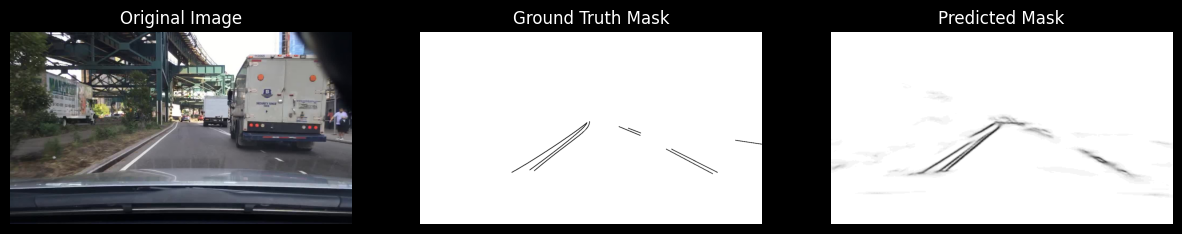

In [26]:

from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

plt.style.use('dark_background')

class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.W_x = nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # g: gating signal from the decoder
        # x: feature map from the encoder
        g = self.W_g(g)
        x = self.W_x(x)

        # Combine the two signals
        attn = self.relu(g + x)
        attn = self.psi(attn)
        attn = self.sigmoid(attn)

        # Apply the attention map to the feature map x
        return x * attn


class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attn4 = AttentionGate(512, 512, 256)  # Attention Gate for the skip connection
        self.dec4 = CBR(768, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn3 = AttentionGate(256, 256, 128)  # Attention Gate for the skip connection
        self.dec3 = CBR(384, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attn2 = AttentionGate(128, 128, 64)  # Attention Gate for the skip connection
        self.dec2 = CBR(192, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attn1 = AttentionGate(64, 64, 32)  # Attention Gate for the skip connection
        self.dec1 = CBR(96, 64)

        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding path
        # dec4
        dec4 = self.upconv4(bottleneck)
        attn4 = self.attn4.forward(enc4, dec4)  # Apply attention gate
        dec4 = torch.cat((attn4, dec4), dim=1)  # Concatenate attention output and upsampled feature map
        dec4 = self.dec4(dec4)  # Adjust the number of input channels expected here

        # dec3
        dec3 = self.upconv3(dec4)
        attn3 = self.attn3.forward(enc3, dec3)  # Apply attention gate
        dec3 = torch.cat((attn3, dec3), dim=1)
        dec3 = self.dec3(dec3)

        # dec2
        dec2 = self.upconv2(dec3)
        attn2 = self.attn2.forward(enc2, dec2)  # Apply attention gate
        dec2 = torch.cat((attn2, dec2), dim=1)
        dec2 = self.dec2(dec2)

        # dec1
        dec1 = self.upconv1(dec2)
        attn1 = self.attn1.forward(enc1, dec1)  # Apply attention gate
        dec1 = torch.cat((attn1, dec1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.conv(dec1))

# Load the trained model
model_with_attention = UNetWithAttention(in_channels=3, out_channels=1).cuda()
model_with_attention.load_state_dict(torch.load('./attention/best_unet_lane_detection.pth', map_location=torch.device('cpu'))['model_state_dict'])
model_with_attention.eval()

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size used during training
    transforms.ToTensor()
])

# Function to preprocess the image and mask
def preprocess(image_path, mask_path):
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')  # Grayscale for mask
    original_size = image.size  # Keep original size
    image = transform(image)
    mask = transform(mask)
    return image, mask, original_size

# Function to post-process the output
def postprocess(output, original_size):
    output = output.squeeze().cpu().numpy()
    output = np.uint8(output * 255)  # Scale to 0-255
    output = Image.fromarray(output).resize(original_size, Image.BILINEAR)
    output = np.array(output)
    return output

# Function to display the results
def display_results(image_path, mask_path, predicted_mask):
    original_image = Image.open(image_path).convert('RGB')
    ground_truth_mask = Image.open(mask_path).convert('L')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask,cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis('off')

    plt.show()

def run_inference(image_path, mask_path):
    image, mask, original_size = preprocess(image_path, mask_path)
    image = image.unsqueeze(0).cuda()  # Add batch dimension

    with torch.no_grad():
        output = model_with_attention(image)
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities

    predicted_mask = postprocess(output, original_size)

    # Save predicted mask
    save_folder = './Dataset/Predicted'
    os.makedirs(save_folder, exist_ok=True)
    predicted_mask_image = Image.fromarray(predicted_mask)
    predicted_mask_image.save(os.path.join(save_folder, os.path.basename(mask_path)))

    display_results(image_path, mask_path, predicted_mask)

# Example usage
image_path = './Dataset/100k_images_val_small_data/bdd100k/images/100k/val/b1e0c01d-dd9e6e2f.jpg'
mask_path = './Dataset/bdd100k_lane_labels_trainval_small_data/bdd100k/labels/lane/masks/val/b1e0c01d-dd9e6e2f.png'
run_inference(image_path, mask_path)